# Exploratoin 01  
### 인공지능과 가위바위보 하기
***
#### 손글씨 이미지 분류기를 tensorflow 의 keras를 활용하여 제작하고 이를 응용하여 가위바위보 이미지를 분류하는 프로젝트

일반적인 딥러닝 기술은 아래의 순서로 이루어지며, 이 순서대로 프로젝트를 진행해보자.
#### 데이터 준비 -> 딥러닝 네트워크 설계 -> 학습 -> 테스트(평가)

In [14]:
from PIL import Image
import os
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras

print("PIL 라이브러리 import 완료!")

PIL 라이브러리 import 완료!


***
#### 딥러닝 네트워크를 구축하는데 필요한 라이브러리를 import
- PIL : 이미지 데이터의 리사이징을 위해 사용, 해당 프로젝트에서는 224x224 사이즈의 이미지를 28 사이즈로 리사이징.

## 1. 데이터 준비
***

In [2]:
def resize_images(img_path):
	images = glob.glob(img_path + "/*.jpg")  
    
	print(len(images), " images to be resized.")

    # 파일마다 모두 28x28 사이즈로 바꾸어 저장합니다.
	target_size=(28,28)
	for img in images:
		old_img=Image.open(img)
		new_img=old_img.resize(target_size,Image.ANTIALIAS)
		new_img.save(img, "JPEG")
    
	print(len(images), " images resized.")
	


`resize_images(img_path)`   ;   이미지 사이즈를 리사이징하는 함수 선언
 - `img_path` 내부에서 ".jpg" 로 끝나는 항목들을 `images` 변수에 리스트 형태로 저장
 - 저장한 이미지를 `old_img` 변수에 다시 저장.
 - `old_img`를 `new_img`에 28x28 사이즈로 변환하여 저장
   

In [3]:
# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/train_data/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")
print("==============================")




# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/train_data/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")
print("==============================")



# 보자기 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/train_data/paper"
resize_images(image_dir_path)
print("보 이미지 resize 완료!")

600  images to be resized.
600  images resized.
가위 이미지 resize 완료!
600  images to be resized.
600  images resized.
바위 이미지 resize 완료!
600  images to be resized.
600  images resized.
보 이미지 resize 완료!


***
'가위', '바위', '보'에 해당하는 이미지들을 `resize_imgs`를 이용해 각각 저장

*local 환경에서 작업을 진행하였기에, 경로가 기존의 설정과 달라짐*



In [4]:
def load_data(img_path, number_of_data = 1800):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size = 28
    color=3
    
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs   = np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels = np.zeros(number_of_data, dtype = np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0   # 가위 : 0
        idx = idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 1   # 바위 : 1
        idx = idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:] = img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 2   # 보 : 2
        idx = idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/train_data"
(x_train, y_train)=load_data(image_dir_path)
x_train_norm = x_train/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 1800 입니다.
x_train shape: (1800, 28, 28, 3)
y_train shape: (1800,)


***
`load_data`; 이미지 데이터를 라벨링하는 매트릭스 생성
 - 이미지의 총 개수가 1800개 이므로, 이에 맞게 `number_of_data`에 입력
 - jpg 파일의 경우 채널이 RGB 3개로, 이에 맞게 `color` 에 입력
 - 각각의 경로에 의하여 이미지들을 불러오고 '가위 : 0', '바위 : 1', '보 : 2' 로 라벨링하여 저장
 - `x_train` 은 학습데이터, `y_train` 은 해당 이미지를 라벨링한 값을 의미
 - `x_train_norm = x_train/255.0` ; 이미지 정규화
     - 실제 픽셀값은 0 ~ 255 값으로 되어있으므로, 0 ~ 1 사이의 값이 될 수 있도록 정규화

라벨:  0


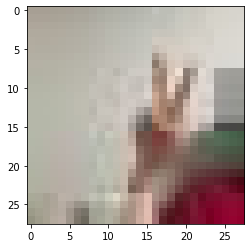

In [5]:
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

라벨:  1


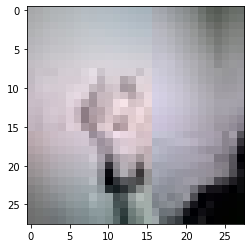

In [15]:
plt.imshow(x_train[720])
print('라벨: ', y_train[720])

***
경로에 맞게 이미지가 잘 불러 오는 지 확인
 - 인덱스가 `[0]` 일 때는 가위,  `[720]` 일 때는 주먹이 나와야 함

해당 이미지에 맞는 라벨링이 부여되었는 지 확인

In [7]:
# 학습용 데이터 수, 크기, 색상(RGB)
print(x_train.shape)

(1800, 28, 28, 3)


## 2. 딥러닝 네트워크 설계하기
***

In [16]:
# 딥러닝 네트워크 학습
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))
model.summary()

Model에 추가된 Layer 개수:  9
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 1600)              0         
                                                                 
 dense_4 (Dense)             (

***
### 딥러닝 네트워크 설계


tensorflow 라이브러리의 keras를 이용하여 딥러닝 네트워크를 설계

`model.add(keras.layers.Conv2D()`
 - Cond2D 레이어의 첫 번째 인자는 사용하는 이미지 특징의 수를 의미하며 위 코드에서는 먼저 32개의 이미지 특징을 고려한 후 64개의 이미지를 고려
 
`model.add(keras.layers.Dense()`
 - Dense 레이어의 첫 번째 인자는 분류기에 사용되는 뉴런의 수를 의미하며 이 값이 클 수록 복잡한 분류기를 만들 수 있음.
 - `activation='softmax'`는 최종 분류기를 의미하며, 분류하고자 하는 class가 몇개인지를 입력한다. 해당 문제에서는 3.
 

## 3. 학습
***

In [9]:
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

model.fit(x_train, y_train, epochs = 8)

Epoch 1/8
57/57 [==============================] - 1s 11ms/step - loss: 2.4870 - accuracy: 0.4522
Epoch 2/8
57/57 [==============================] - 1s 11ms/step - loss: 0.7097 - accuracy: 0.6894
Epoch 3/8
57/57 [==============================] - 1s 12ms/step - loss: 0.4719 - accuracy: 0.8200
Epoch 4/8
57/57 [==============================] - 1s 11ms/step - loss: 0.2330 - accuracy: 0.9306
Epoch 5/8
57/57 [==============================] - 1s 11ms/step - loss: 0.1476 - accuracy: 0.9606
Epoch 6/8
57/57 [==============================] - 1s 10ms/step - loss: 0.1083 - accuracy: 0.9639
Epoch 7/8
57/57 [==============================] - 1s 11ms/step - loss: 0.0562 - accuracy: 0.9872
Epoch 8/8
57/57 [==============================] - 1s 11ms/step - loss: 0.0297 - accuracy: 0.9950


***
epochs 는 학습 횟수를 의미하며, 초기에 10으로 두었을 시에 9회에서 이미 accuracy 가 1.0000에 도달하였기에, 학습횟수를 8회로 조정하였다.

## 4. 테스트
***

In [10]:

# 가위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/test_data/scissor"
resize_images(image_dir_path)
print("가위 이미지 resize 완료!")
print("==============================")


# 바위 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/test_data/rock"
resize_images(image_dir_path)
print("바위 이미지 resize 완료!")
print("==============================")


# 보 이미지가 저장된 디렉토리 아래의 모든 jpg 파일을 읽어들여서
image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/test_data/paper"
resize_images(image_dir_path)

print("보 이미지 resize 완료!")

100  images to be resized.
100  images resized.
가위 이미지 resize 완료!
100  images to be resized.
100  images resized.
바위 이미지 resize 완료!
100  images to be resized.
100  images resized.
보 이미지 resize 완료!


In [11]:

def load_data(img_path, number_of_data = 300):  # 가위바위보 이미지 개수 총합에 주의하세요.
    # 가위 : 0, 바위 : 1, 보 : 2
    img_size = 28
    color=3 
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성합니다.
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissor/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 바위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1
        
    print("테스트 데이터(x_test)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/python/workspace/exploration/ex01/data/test_data"
(x_test, y_test)=load_data(image_dir_path)
x_test_norm = x_test/255.0   # 입력은 0~1 사이의 값으로 정규화

print("x_train shape: {}".format(x_test.shape))
print("y_train shape: {}".format(y_test.shape))

테스트 데이터(x_test)의 이미지 개수는 300 입니다.
x_train shape: (300, 28, 28, 3)
y_train shape: (300,)


학습 데이터를 만들 때와 동일하지만, 이미지 데이터가 저장된 경로가 다르며 데이터의 개수도 다르기 때문에 해당 인자에 대한 수를 수정하여 입력한다.

라벨:  0


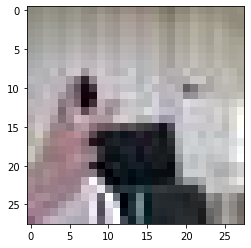

In [12]:
plt.imshow(x_test[0])
print('라벨: ', y_test[0])

## 평가

In [13]:
test_loss, test_accuracy = model.evaluate(x_test,y_test, verbose=2)
print("test_loss: {} ".format(test_loss))
print("test_accuracy: {}".format(test_accuracy))

10/10 - 0s - loss: 2.4342 - accuracy: 0.6333 - 158ms/epoch - 16ms/step
test_loss: 2.4342286586761475 
test_accuracy: 0.6333333253860474


***
목표 정확도에 해당하는 **0.6**을 넘긴, **0.6333** 이 accuracy 로 출력되는 것을 볼 수 있다.

# 회고
***

## 1. 프로젝트에 사용된 모델에 대한 평가


#### 1) Training Set 에 대한 평가

    최초의 Training set은 내가 만든 가위,바위,보 사진을 이용해 100개씩 총 300개로 구성하여 모델을 학습시키고, 150개의 Test set에 대한 정확도를 예측하는 것으로 실험을 진행하였다.  이 때 최초로 측정된 정확도는 약 정확도는 약 33% 였으며, 같은 코드로 반복해서 실행시킨 결과 30% ~ 35% 정도로 나온 것을 확인할 수 있었다. 학습을 진행시키지 않았을 때의 정확도가 33%일 것이라 예측하여 코드상의 문제는 발생하지 않은 것으로 판단한 후 Training set의 개수를 다른 사람이 만든 데이터들을 이용해 각각 100개, 총 300개 단위로 높여가며 실험을 진행하였다.
    
    Training set의 개수가 60개, 900개일 경우에는 기존 300개로 진행 했을 때와 유의미한 차이 없이 정확도가 거의 비슷하게 측정되었으며, 이후 1200개 에서는 정확도가 42% ~ 45% 까지 폭넓게 측정 되었다. 
    Training set 1500개로 실험할 시에는 Test set 또한 50개를 추가하였는데 추가된 Test set 에 대한 정확도가 높았는 지, 50% 이상의 정확도를 유지하고 60%에 거의 가까운 정확도까지 측정되는 경우도 있었다.
    
    Training set 의 개수를 1800개, Test set 의 개수는 유지하며 실험을 진행한 결과, 60% 넘는 정확도를 보여주었다. 다만 반복해서 실행한 결과 60%를 넘지 못하는 경우도 있었다.
    
    이후, Training set 의 개수를 2700개 까지 높여서 실험을 진행 하였을 때, 실험을 시행할 때에 따른 편차가 매우 컸으며 때로는 60%를 초과하는 경우도 있고, 때로는 50%도 나오지 않을 때가 있었다. Training set 을 1800개로 하였을 때 까지는 어느 정도 데이터에 대한 선별을 하였으나, 2700개로 진행하였을 때에는 이러한 과정이 빠져서 발생한 일로 보인다.
    
    

    

#### 2) Hyperparameter 에 대한 평가
    딥러닝 네트워크를 구축하는데에 있어 설정해 두었던 Hyperparameter에 따라서도 정확도가 달라질 수 있다. 
    
    처음에는 Hyperparameter 에 대한 이해도가 부족한 이유로 Hyperparameter의 숫자를 너무 작게하여 특징수가 너무 적게 나왔으나, 후에 parameter를 수정하여 최소 3만개의 특징을 고려하는 모델로 만들어 실험을 진행하였다.
    
    최종 테스트에서는 최초로 32개의 이미지 특징을 고려한 후, 64개의 이미지를 고려하고 이후에 32 - 16 - 8 - 3 순으로 이미지가 분류될 수 있도록 설계하여 총 특징 수는 71,315개가 나왔다.
    
    Hyperparameter에 대해서는 이해도가 낮아 해당 분류기에 더 적합한 수를 찾지 못했을 가능성이 높다.

## 2. 모델의 정확도를 높이는 방안

    Training set의 화질을 높이는 것을 첫 번째 방안으로 할 수 있다. 이번 프로젝트의 경우 이미지 사이즈를 28x28로 진행하였기 때문에 원본에 비하여 이미지간의 구별이 어려울 수 있다. 다만 원본 이미지를 썼을 때와, 리사이징된 이미지를 썼을 때 발견되는 특징 수가 서로 다를 수 있으므로 화질에 대한 적합한 Hyperparameter를 고려해서 모델을 구상해야 할 것이다.
    
    두번째로 학습데이터 가위, 바위, 보 간의 구별이 확실한 데이터로 구성하는 것이다. 각각 라벨링된 데이터들 간의 특징들이 명확하게 다르다면 딥러닝 네트워크가 보다 쉽고 높은 정확도로 Test set을 예측할 것이다.
    
    세번째로 첫번째에서 언급했던 Hyperparameter를 모델에 맞게 적절하게 설정하는 것이다. 이번 프로젝트 같은 이미지 분류에 대해서는 이미지, 분류 라벨의 수에 따라 찾고자 하는 특징의 수가 차이가 있을 것이므로 이에 적절한 Hyperparamter를 설정해야 보다 정확한 실험이 될 것이다. 다만, 이부분에 대해서는 아직 공부가 부족하여 조금 더 이론적으로 학습을 해야함을 다른 방안에 비해 더욱 실감하였다.
    
    마지막으로 Overfitting 을 대비하여 적절한 epochs를 두는 것이다. 이번 실험에서도 overfitting을 방지하기 위해 다양한 사람의 데이터 셋을 이용한점, 정규화를 시행한 점 등이 있지만 너무 높은 epochs 를 두어 Training set 과 Test set 간의 차이가 클 경우 정확한 예측이 되지 않을 수 있기에 이에 맞는 적절한 epochs을 찾아 그에 맞게 학습을 해야 더욱 정확한 모델이 될 것으로 보인다.

## 3. 소감


    첫 Exploration Node를 진행하면서 여태 학습한 내용을 실제로 사용해 보면서 흥미롭기도 하면서 한편으로는 정확도가 원하는대로 잘 올라가지 않아 답답함도 있었던 것 같다. 이에 대해서는 추후 진행할 학습과정을 통하여 점차점차 극복할 것이라 희망한다.

## 4. Reference

https://github.com/LilPark/AIFFEL_project/blob/main/Exploration_01/%5BE-01%5DRockPaperScissor.ipynb

*첫 노드를 진행함에 있어 주석처리, 회고작성을 어떻게 처리해야 할 지에 대해 참고하였다.*